In [1]:
import pandas as pd
import numpy as np
import os
import re
import csv
import json
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import squareform
from unidecode import unidecode
from tslearn.metrics import dtw
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
from scipy.interpolate import interp1d
from dtw import *
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean

/usr/local/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# 📦 Preparing data for dev

In [27]:
# Simplifying pitch files

def resample_data(file_path, resample_rule, frequency_sigfigs=2):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df[df['frequency'] > 0].set_index('timestamp').resample(resample_rule).mean().reset_index()
    df['frequency'] = df['frequency'].round(frequency_sigfigs)
    return df

def process_files(ids_df, source_folder, resample_rule, frequency_sigfigs=2, phrase_num=None):
    result_df = pd.DataFrame()

    for id in ids_df['id']:
        file_path = f"{source_folder}/{id}_pitch.csv"
        resampled_data = resample_data(file_path, resample_rule, frequency_sigfigs)

        if phrase_num is not None:
            start_col = f'phrase{phrase_num}_start'
            end_col = f'phrase{phrase_num}_end'
            start_time = ids_df.loc[ids_df['id'] == id, start_col].iloc[0]
            end_time = ids_df.loc[ids_df['id'] == id, end_col].iloc[0]

            start_time = pd.to_datetime(start_time, unit='s')
            end_time = pd.to_datetime(end_time, unit='s')

            resampled_data = resampled_data[(resampled_data['timestamp'] >= start_time) & (resampled_data['timestamp'] <= end_time)]

        # Normalize 'timestamp' to start from 0 for each ID
        earliest_timestamp = resampled_data['timestamp'].min()
        resampled_data['timestamp'] = (resampled_data['timestamp'] - earliest_timestamp).dt.total_seconds().round(frequency_sigfigs)

        resampled_data.rename(columns={'frequency': id}, inplace=True)

        if result_df.empty:
            result_df = resampled_data
        else:
            result_df = pd.merge(result_df, resampled_data, on='timestamp', how='outer')

    result_df = result_df.sort_values(by='timestamp')

    return result_df

ids_df = pd.read_csv("for-dev/ids.csv")

# Zoomed OUT, less data needed
zoomed_out_desktop_data = process_files(ids_df, 'pitch-transposed', '.1S', frequency_sigfigs=2)
zoomed_out_mobile_data = process_files(ids_df, 'pitch-transposed', '1S', frequency_sigfigs=2)

zoomed_out_desktop_data.to_csv("for-dev/pitch/desktop/full.csv", index=False)
zoomed_out_mobile_data.to_csv("for-dev/pitch/mobile/full.csv", index=False)

# Zoomed IN on each phrase
for i in range(16):
    print(i)
    desktop = process_files(ids_df, 'pitch-transposed', '.05S', frequency_sigfigs=2, phrase_num=i)
    mobile = process_files(ids_df, 'pitch-transposed', '.5S', frequency_sigfigs=2, phrase_num=i)

    desktop.to_csv(f"for-dev/pitch/desktop/phrase{i}.csv", index=False)
    mobile.to_csv(f"for-dev/pitch/mobile/phrase{i}.csv", index=False)
print('done')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
done


In [25]:
# ids file - meta info for each performance
def combine_ids_file(ids_csv_path, json_folder_path, diva_csv_path, output_csv_path):
    # Read the ids.csv and diva_per_phrase.csv files
    ids_df = pd.read_csv(ids_csv_path)
    diva_df = pd.read_csv(diva_csv_path)

    for id in ids_df['id']:
        # Load JSON data for phrase starts and ends
        json_file_path = os.path.join(json_folder_path, f"{id}_fixed_phrases.json")
        with open(json_file_path, 'r') as file:
            data = json.load(file)

        for i, phrase in enumerate(data):
            # Convert to float and round if start and end values are not None
            start = round(float(phrase['start']), 1) if phrase['start'] is not None else None
            end = round(float(phrase['end']), 1) if phrase['end'] is not None else None
            ids_df.loc[ids_df['id'] == id, f'phrase{i}_start'] = start
            ids_df.loc[ids_df['id'] == id, f'phrase{i}_end'] = end

        # Add diva values for each phrase
        for i in range(16):
            diva_col = f'diva_phrase_{i + 1}'
            if diva_col in diva_df.columns:
                diva_value = diva_df.loc[diva_df['id'] == id, diva_col].values[0]
                # Round the value if it's not NaN or None
                ids_df.loc[ids_df['id'] == id, f'phrase{i}_diva'] = round(diva_value, 1) if pd.notna(diva_value) else None

    # Save the updated DataFrame
    ids_df.to_csv(output_csv_path, index=False)

combine_ids_file('ids.csv', 'phrase-starts-and-ends-by-id', 'diva_per_phrase.csv', 'for-dev/ids.csv')
print('done')

done


In [26]:
# genre and event type
def simplify_and_export(input_csv_path, output_csv_path, threshold=10):
    df = pd.read_csv(input_csv_path)
    filtered_df = df[df['num_performances'] > threshold].copy()
    filtered_df['avg_diva'] = filtered_df['avg_diva'].round(1)
    filtered_df.to_csv(output_csv_path, index=False)

simplify_and_export('diva_per_artistGenre.csv', 'for-dev/diva_by_genre.csv', 10)
simplify_and_export('diva_per_eventType.csv', 'for-dev/diva_by_event.csv', 7)
print('done')

done


In [23]:
# standard block data processing
def transpose(original_hz, steps_from_C):
    return original_hz * (2 ** ((steps_from_C * -1) / 12))

def compute_average_lengths(ids_file):
    ids_df = pd.read_csv(ids_file)
    averages = {}
    for col in ids_df.columns:
        if col.endswith('_start'):
            phrase = col[:-6]
            averages[phrase] = (ids_df[phrase + '_end'] - ids_df[phrase + '_start']).median() # actually median
    return averages

def elongate_timestamps(words_df, averages):
    for phrase in averages:
        phrase_num = int(phrase.replace('phrase', ''))
        phrase_df = words_df[words_df['phrase'] == phrase_num]
        
        if not phrase_df.empty:
            start = phrase_df['timestamp'].min()
            phrase_end = phrase_df['timestamp'] + phrase_df['duration']
            end = phrase_end.max()
            target_duration = averages[phrase]

            # Calculate stretch factor
            stretch_factor = target_duration / (end - start) if end - start else 1

            # Apply the stretch to timestamps
            words_df.loc[phrase_df.index, 'timestamp'] = (words_df.loc[phrase_df.index, 'timestamp'] - start) * stretch_factor + start

    return words_df

standard_words_df = pd.read_csv('standard_words.csv')
standard_words_df['frequency'] = standard_words_df['frequency'].apply(lambda hz: transpose(hz, 10))
average_lengths = compute_average_lengths('for-dev/ids.csv')
print(average_lengths)
elongated_standard_df = elongate_timestamps(standard_words_df, average_lengths)

# sig figs
elongated_standard_df['timestamp'] = elongated_standard_df['timestamp'].round(2)
elongated_standard_df['frequency'] = elongated_standard_df['frequency'].round(2)
elongated_standard_df['duration'] = elongated_standard_df['duration'].round(2)

elongated_standard_df.to_csv('for-dev/processed_standard_words.csv', index=False)
print('done')

{'phrase0': 5.1000000000000005, 'phrase1': 4.9, 'phrase2': 5.0, 'phrase3': 4.900000000000002, 'phrase4': 5.0, 'phrase5': 4.899999999999999, 'phrase6': 4.900000000000006, 'phrase7': 5.0, 'phrase8': 5.100000000000001, 'phrase9': 5.100000000000001, 'phrase10': 4.899999999999999, 'phrase11': 5.200000000000003, 'phrase12': 6.0, 'phrase13': 6.700000000000003, 'phrase14': 7.599999999999994, 'phrase15': 10.699999999999989}
done


# 🧹 CSV cleaning

begin with `ids.csv`, `/pitch`, `/words` populated from the spreadsheet.

1. make sure filenames in `/pitch` and `/words` are valid ids
2. make sure all csvs are formatted with the correct columns
3. in `/words`, group words into phrases
4. in `/words`, group words uniquely
5. in `/pitch`, transpose notes to the standard key
6. write cleaned data to `/pitch-transposed` and `/words-phrased`

In [12]:
def clean():
    folders = ['pitch', 'words']

    missing_ids = check_ids()
    
    print('Checking that ids.csv and /pitches /words match')
    if len(missing_ids) > 0:
        print(f"{len(missing_ids)} missing files.")
        print(missing_ids)
#         return
    else:
        print('All good ✅')
    
    invalid_csvs = check_csvs(folders)
    
    print('Checking valid csv format')
    if (len(invalid_csvs) > 0):
        print(f"{len(invalid_csvs)} invalid csvs.")
        print(invalid_csvs)
        return
    else:
        print('All good ✅')
        
    with open('ids.csv', 'r') as file:
        reader = csv.reader(file)
        row_count = sum(1 for row in reader)
    print(f"{row_count - 1} national anthems ready to analyze.")
    
#     print('Cleaning /words - phrasing')
#     clean_words()
#     print('Done ✅')
    
    print('Cleaning /pitch - transposing')
    clean_pitch()
    print('Done ✅')

clean()

Checking that ids.csv and /pitches /words match
1 missing files.
['standard(words file)']
Checking valid csv format
All good ✅
137 national anthems ready to analyze.
Cleaning /pitch - transposing
1: patrick-stump_world-series_2016_pitch.csv
2: gretchen-wilson_nba-allstar-game_2010_pitch.csv
3: kelly-clarkson_indy-500_2019_pitch.csv
4: carly-pearce_world-series_2021_pitch.csv
5: trisha-yearwood_world-series_2014_pitch.csv
6: kelly-clarkson_world-series_2010_pitch.csv
7: jordan-smith_nfl-regular-season_2023_pitch.csv
8: luke-bryan_super-bowl_2017_pitch.csv
9: fergie_nba-allstar-game_2018_pitch.csv
10: alicia-keys_super-bowl_2013_pitch.csv
11: hunter-hayes_world-series_2016_pitch.csv
12: taylor-swift_world-series_2008_pitch.csv
13: jordin-sparks_super-bowl_2008_pitch.csv
14: demi-lovato_world-series_2015_pitch.csv
15: melissa-etheridge_world-series_2002_pitch.csv
16: juanita-booker_inauguration_1981_pitch.csv
17: cheryl-ladd_super-bowl_1980_pitch.csv
18: diana-ross_super-bowl_1982_pitch.c

In [4]:
def check_ids():
    missing_ids = []
    existing_ids = set()

    with open('ids.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            id_value = row['id']
            existing_ids.add(id_value)
            words_file = f'words/{id_value}_words.csv'
            pitch_file = f'pitch/{id_value}_pitch.csv'

            if not os.path.isfile(words_file):
                missing_ids.append(id_value + '(words file)')
            if not os.path.isfile(pitch_file):
                missing_ids.append(id_value + '(pitch file)')

    for folder in ['words', 'pitch']:
        for file in os.listdir(folder):
            if file.endswith('.csv'):
                file_id = '_'.join(file.rsplit('_', 1)[0:-1])
                if file_id not in existing_ids:
                    missing_ids.append(file_id + ' missing in ids.csv')

    return missing_ids

In [5]:
def check_csv_columns(file_path, expected_columns):
    with open(file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) != len(expected_columns):
                return False
    return True

def check_csvs(folders):
    invalid_csvs = []
    for folder in folders:
        expected_columns = ["timestamp", "frequency"] if folder == 'pitch' else ["timestamp", "frequency", "duration", "word"]

        for filename in os.listdir(folder):
            if not filename.endswith('.csv'): 
                continue
            
            valid = check_csv_columns(os.path.join(folder, filename), expected_columns)
            if not valid:
                invalid_csvs.append(os.path.join(folder, filename))

    return invalid_csvs   

In [6]:
def clean_words():
    output_folder = 'words-unique' # 'words-phrased'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    ids = pd.read_csv('ids.csv')
    for id in ids['id']:
        filename = f'words/{id}_words.csv'
        if os.path.exists(filename):
            words = pd.read_csv(filename)          
            # words_cleaned = add_phrases(words)
            words_cleaned = unique_word_labels(words)
            words_cleaned.to_csv(f'{output_folder}/{id}.csv', index=False)
        
phrases = ['o-say-can-you-see', 'by-the-dawns-early-light', 'what-so-proudly-we-hailed', 'at-the-twilights-last-gleaming', 'whose-broad-stripes-and-bright-stars', 'through-the-perilous-fight', 'oer-the-ramparts-we-watched', 'were-so-gallantly-streaming', 'and-the-rockets-red-glare', 'the-bombs-bursting-in-air', 'gave-proof-through-the-night', 'that-our-flag-was-still-there', 'o-say-does-that-star-spangled', 'banner-yet-wave', 'oer-the-land-of-the-free', 'and-the-home-of-the-brave']
        
def add_phrases(words):
    words['phrase'] = None
    
    phrase_idx = 0
    word_idx = 0

    for i, row in words.iterrows():
        current_phrase = phrases[phrase_idx]
        if row['word'] not in current_phrase:
            phrase_idx += 1
            
        words.at[i, 'phrase'] = phrases[phrase_idx]

    return words

def unique_word_labels(data):
    word_count = {}
    last_words = set()
    unique_data = []

    for index, row in data.iterrows():
        original_word = row['word']
        words = original_word.split('-')

        new_words = []
        for word in words:
            # Process each part of a compound word
            if word not in last_words:
                count = word_count.get(word, 0) + 1
                word_count[word] = count

                if count > 1:
                    new_words.append(f"{word}{count}")
                else:
                    new_words.append(word)
            else:
                new_words.append(word)

        unique_word = '-'.join(new_words)

        # Creating a new dictionary with modified word property
        new_item = row.to_dict()
        new_item['word'] = unique_word
        unique_data.append(new_item)

        # Update last_words set
        last_words = set(words)

    return pd.DataFrame(unique_data)

In [7]:
standard_key = 'C'

def clean_pitch(one_file=None):
    output_folder = 'pitch-transposed'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    current_file_number = 0
    for filename in os.listdir('pitch'):
        if not filename.endswith('csv'): continue
        if one_file and filename != one_file: continue
            
        current_file_number += 1
        print(f"{current_file_number}: {filename}")
        
        id_value = filename.replace('_pitch.csv', '')
        id_df = pd.read_csv('ids.csv')
        row = id_df[id_df['id'] == id_value]
        steps_from_C = row['steps_from_C'].iloc[0]
        
        pitch = pd.DataFrame(pd.read_csv('pitch/' + filename))
        
        if steps_from_C == 0:
            pitch_cleaned = pitch
        else:
            pitch_cleaned = normalize_pitch(pitch, steps_from_C)
        
        pitch_cleaned.to_csv(output_folder + '/' + filename, index=False)

def transpose(original_hz, steps_from_C):
    new_frequency = original_hz * (2 ** ((steps_from_C * -1) / 12))
    return new_frequency

def normalize_pitch(pitch_data, steps_from_C):
    normalized = []
    for index, row in pitch_data.iterrows():
        new_row = {col: row[col] for col in pitch_data.columns}
        new_row['frequency'] = transpose(row['frequency'], steps_from_C)
        normalized.append(new_row)
    return pd.DataFrame(normalized)

In [4]:
# Update phrase-starts-and-ends-by-id
undefined_phrases = {
    'marvin-gaye_nba-allstar-game_1983': [0, 9],
    'chloe-bailey_world-series_2022': [0, 9, 12],
    'mariah-carey_super-bowl_2002': [0],
    'whitney-houston_super-bowl_1991': [6],
    'aaron-lewis_world-series_2014': [8],
    'john-oates_world-series_2008': [9],
    'mickey-guyton_world-series_2023': [9],
    'cassadee-pope_stanley-cup-playoffs_2023': [10],
    'rachel-platten_world-series_2016': [10],
    'mary-j-blige_world-series_2009': [10],
    'mary-j-blige_world-series_2013': [13],
    'cher_super-bowl_1999': [15],
    'fantasia_ncaa-football-championship_2023': [0],
    'juanita-booker_inauguration_1981': [3],
    'lady-gaga_super-bowl_2016': [11],
    'kelly-clarkson_world-series_2010': [15],
    'pia-toscano_memorial-day-concert_2022': [15],
    'cheryl-ladd_super-bowl_1980': [15],
    'idina-menzel_mlb-allstar-game_2014': [15],
    
}

directory = "phrase-starts-and-ends-by-id"

def update_files(id, indices):
    filename = f"{directory}/{id}_fixed_phrases.json"
    if os.path.exists(filename):
        with open(filename, "r") as file:
            data = json.load(file)
        
        for i in indices:
            if 0 <= i < len(data):
                data[i]['start'] = None
                data[i]['end'] = None
        
        with open(filename, "w") as file:
            json.dump(data, file, indent=4)
    else:
        print(f"File {filename} does not exist.")

for id, indices in undefined_phrases.items():
    update_files(id, indices)
print('done')

# with open('jan_fixed_ids.csv', mode='r', encoding='utf-8') as csv_file:
#     reader = csv.DictReader(csv_file)

#     for row in reader:
#         id = row['id']
#         phrases = []

#         undefined_indexes = undefined_phrases.get(id, [])

#         for i in range(16):  # Adjusted to 0-based indexing
#             start_key = f'phrase{i}_start'
#             end_key = f'phrase{i}_end'
#             if i in undefined_indexes:
#                 # Set values to None (which will become 'null' in JSON)
#                 phrase_data = {'start': None, 'end': None}
#             elif start_key in row and end_key in row:
#                 # Normal case, get start and end values
#                 phrase_data = {'start': row[start_key], 'end': row[end_key]}
#             else:
#                 # If for some reason the phrase doesn't exist, set both to None
#                 phrase_data = {'start': None, 'end': None}

#             phrases.append(phrase_data)

#         file_path = f'phrase-starts-and-ends-by-id/{id}_fixed_phrases.json'
#         with open(file_path, mode='w', encoding='utf-8') as json_file:
#             json.dump(phrases, json_file, indent=4)
# print('done')

done


# 📈 Plotting pitch data

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


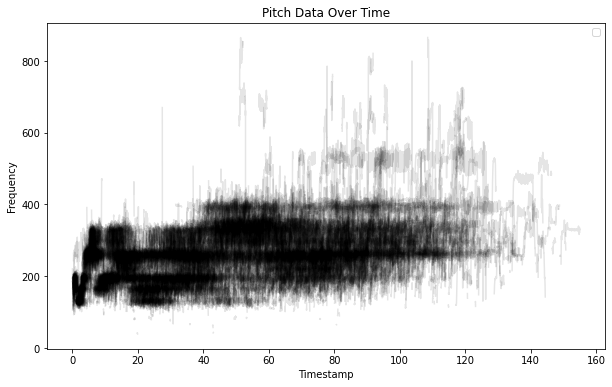

In [13]:
def plot_all_pitches(exclude):
    plt.figure(figsize=(10, 6))

    for filename in os.listdir('pitch-transposed'):
        if filename.endswith('.csv') and filename not in exclude:
            file_path = os.path.join('pitch-transposed', filename)

            # Read the CSV file
            data = pd.read_csv(file_path)

            # Process the data to create disconnected segments
            # Group the data by consecutive non-zero frequency values
            data['group'] = (data['frequency'] == 0).cumsum()
            grouped = data[data['frequency'] != 0].groupby('group')

            # Plot each segment
            for _, segment in grouped:
                plt.plot(segment['timestamp'], segment['frequency'], color='black', alpha=0.1)

    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.title('Pitch Data Over Time')
    plt.legend()
    plt.show()

exclude = []
plot_all_pitches(exclude)

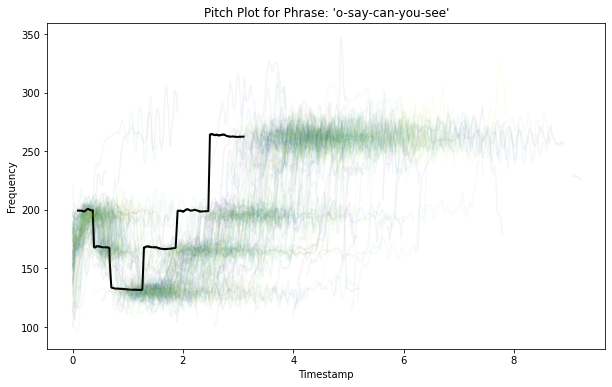

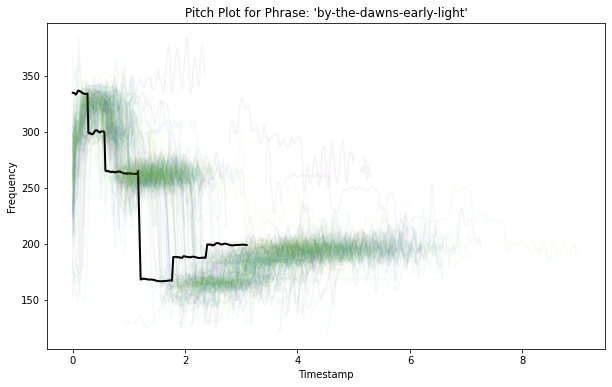

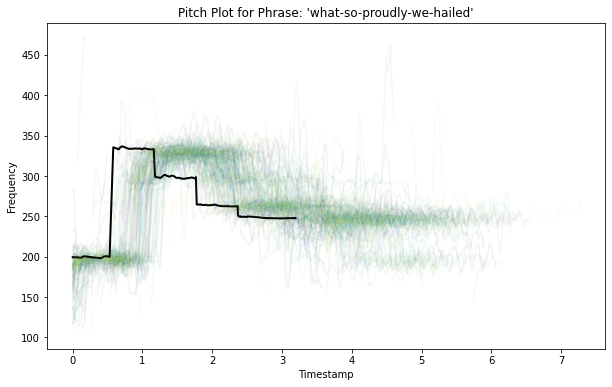

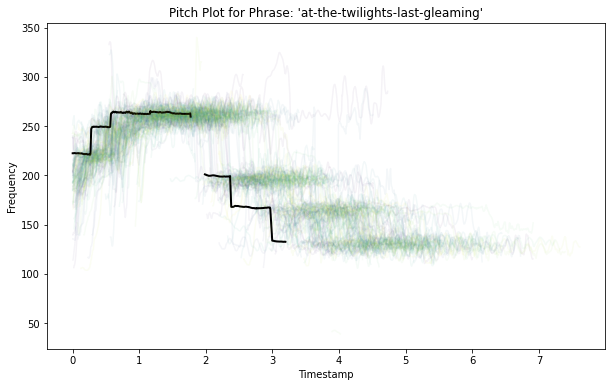

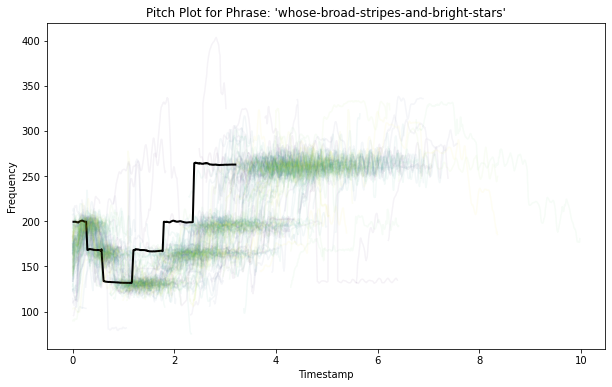

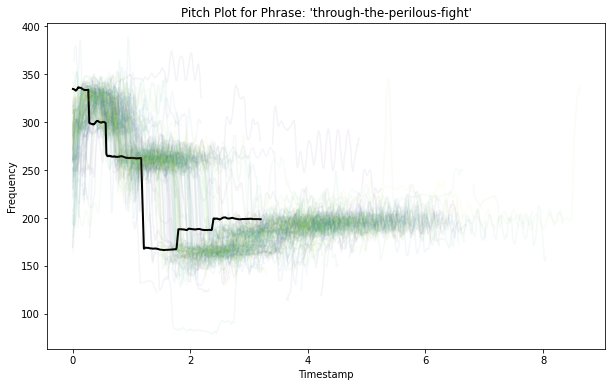

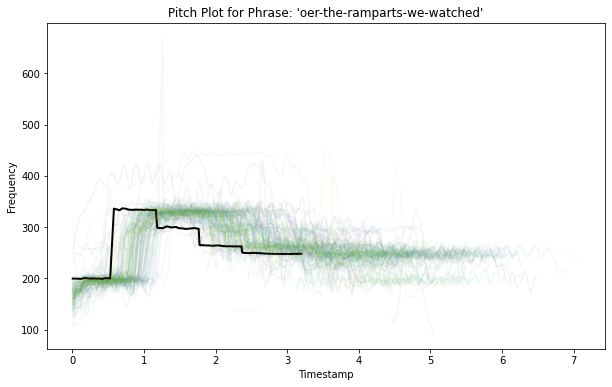

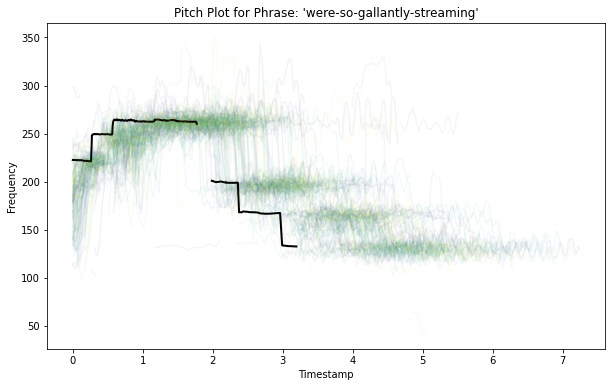

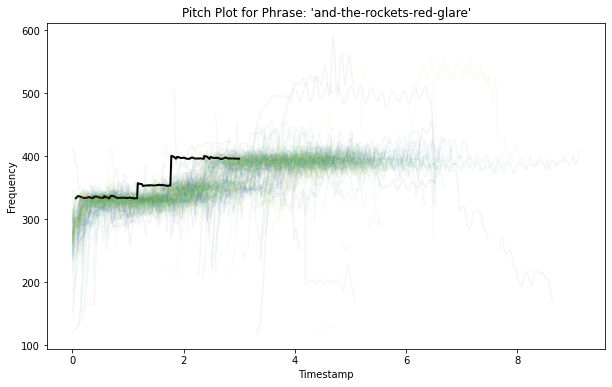

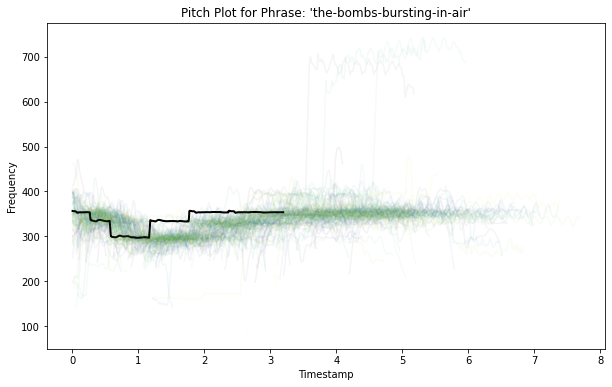

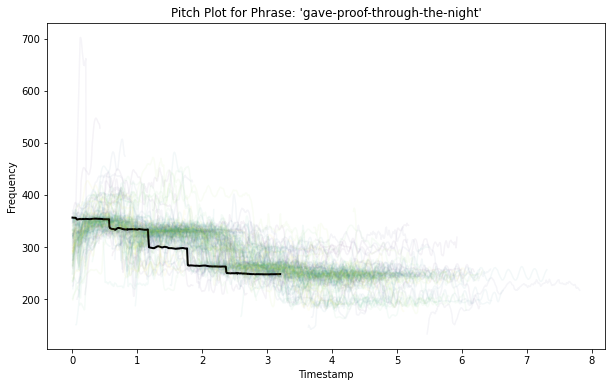

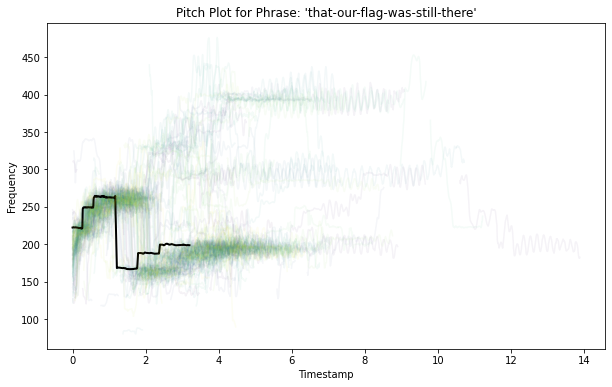

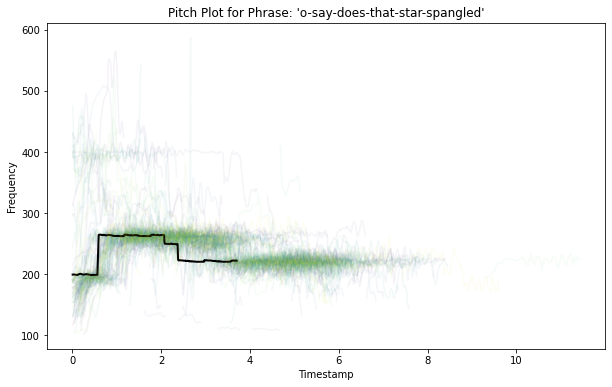

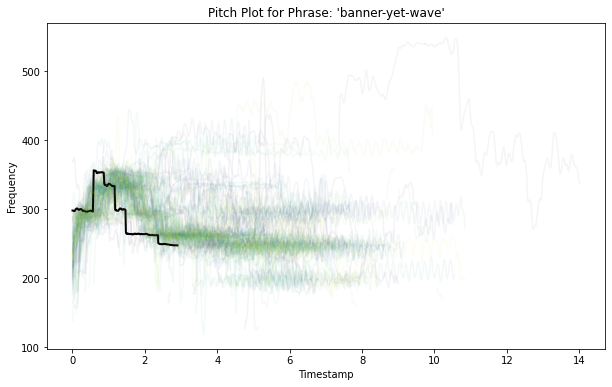

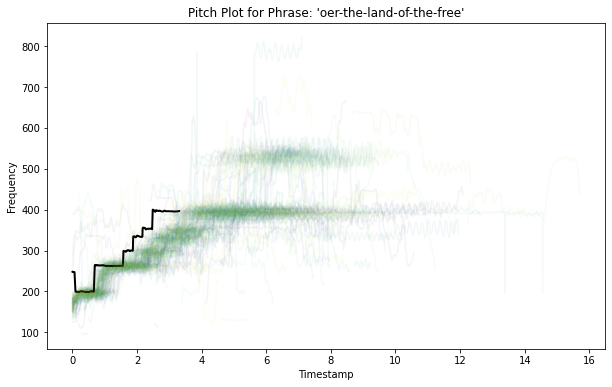

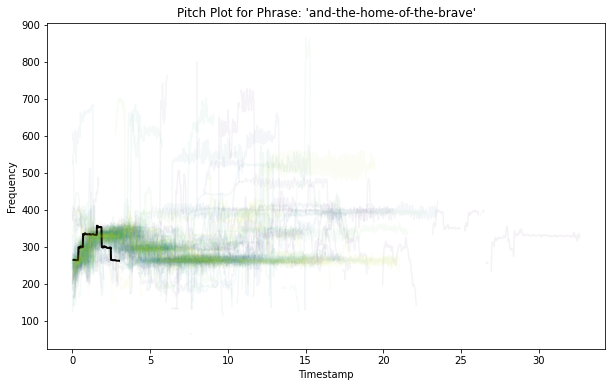

In [2]:
phrases = ['o-say-can-you-see', 'by-the-dawns-early-light', 'what-so-proudly-we-hailed', 'at-the-twilights-last-gleaming', 'whose-broad-stripes-and-bright-stars', 'through-the-perilous-fight', 'oer-the-ramparts-we-watched', 'were-so-gallantly-streaming', 'and-the-rockets-red-glare', 'the-bombs-bursting-in-air', 'gave-proof-through-the-night', 'that-our-flag-was-still-there', 'o-say-does-that-star-spangled', 'banner-yet-wave', 'oer-the-land-of-the-free', 'and-the-home-of-the-brave']

def plot_pitches_by_phrase(words_path, pitch_path):
    ids = pd.read_csv('ids.csv')['id']

    for idx, phrase in enumerate(phrases):        
        plt.figure(figsize=(10, 6))
        plt.title(f"Pitch Plot for Phrase: '{phrase}'")
        plt.xlabel('Timestamp')
        plt.ylabel('Frequency')
        color_map = {id: 'black' if id == 'standard' else plt.cm.viridis(i/len(ids)) for i, id in enumerate(ids)}
        
        # Initialize a list to store pitch data for each id
        phrase_pitches = []

        for id in ids:
            # Load the fixed phrases data
            json_path = f"phrase-starts-and-ends-by-id/{id}_fixed_phrases.json"
            if os.path.exists(json_path):
                with open(json_path, 'r') as json_file:
                    fixed_phrases = json.load(json_file)
                
                # Get the current phrase_data based on the index
                if idx < len(fixed_phrases):
                    phrase_data = fixed_phrases[idx]
                    phrase_start_timestamp = phrase_data.get('start', 0)
                    phrase_end_timestamp = phrase_data.get('end', 0)
                    
                    # Load pitch data and filter by timestamps
                    pitch_df = pd.read_csv(f"{pitch_path}/{id}_pitch.csv")
                    pitch_df = pitch_df[(pitch_df['timestamp'] >= phrase_start_timestamp) & (pitch_df['timestamp'] <= phrase_end_timestamp)]

                    # Adjust timestamps so each curve starts at 0
                    pitch_df['adjusted_timestamp'] = pitch_df['timestamp'] - phrase_start_timestamp
                    
                    # Add the pitch data to the list
                    phrase_pitches.append({'id': id, 'pitch': pitch_df.to_dict(orient='records')})

                    # Split the dataframe into segments where frequency is not 0
                    segments = pitch_df[pitch_df['frequency'] > 0].copy()
                    segments['gap'] = (segments['adjusted_timestamp'].diff() > 0.1) | (segments['frequency'].diff() == 0)
                    for _, segment in segments.groupby((segments['gap'].cumsum())):
                        if id == 'standard':
                            plt.plot(segment['adjusted_timestamp'], segment['frequency'], alpha=1, color=color_map[id], linewidth=2, label=id)
                        else:
                            plt.plot(segment['adjusted_timestamp'], segment['frequency'], alpha=0.05, color=color_map[id])
        
        plt.show()
        
        # Save the pitch data for the phrase as a JSON file
        with open(f"phrases/{phrase}.json", 'w') as f:
            json.dump(phrase_pitches, f, indent=4)
    
plot_pitches_by_phrase('words-phrased', 'pitch-transposed')

In [33]:
def flag_high():
    for filename in os.listdir('pitch-transposed'):
        if not filename.endswith('.csv'): 
            continue

        file_path = os.path.join('pitch-transposed', filename)
        with open(file_path, newline='') as csvfile:
            reader = csv.DictReader(csvfile)

            for row in reader:
                try:
                    frequency = float(row['frequency'])
                    if frequency > 1000:
                        print(filename)
                        print(frequency)
                        break  # Break after the first occurrence in a file
                except ValueError:
                    continue  # Skip rows where frequency cannot be converted to float
    print('done')
flag_high()

done


# 🎤 DIVA scores 

DIVA score = comparing the pitch curve to the standard curve using [Dynamic Time Warping](https://dynamictimewarping.github.io/python/).

In [15]:
def plot_segments(df, title):
    plt.figure(figsize=(12, 4))
    segments = []
    current_segment = []
    for _, row in df.iterrows():
        if row['frequency'] > 0:
            current_segment.append(row)
        elif current_segment:
            segments.append(pd.DataFrame(current_segment))
            current_segment = []
    if current_segment:  # Add the last segment if not empty
        segments.append(pd.DataFrame(current_segment))
    
    # Plot each segment
    for segment in segments:
        plt.plot(segment['timestamp'], segment['frequency'], color="blue")
    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def diva_score(df1, df2):
#     plot_segments(df1, f'Pitch Shape {id}')
#     plot_segments(df2, 'Standard Pitch Shape')

    freq1 = df1['frequency'].values
    freq2 = df2['frequency'].values

    # Apply DTW
    alignment = dtw(freq1, freq2, keep_internals=True)

    # Return the DTW score
    return alignment.distance / 100

def diva_score_word_segmented(df1, df2):
    total_distance = 0
    
    # timestamps1 = list of timestamps for the start ts of each word in df1

    for i in range(len(timestamps1) - 1):
        segment_freq1 = df1.loc[timestamps1[i]:timestamps1[i+1]]['frequency'].values
        segment_freq2 = df2.loc[timestamps2[i]:timestamps2[i+1]]['frequency'].values

        segment_alignment = dtw(segment_freq1, segment_freq2, keep_internals=True)
        total_distance += segment_alignment.distance

    return total_distance / 100

In [43]:
# Trying out improved diva score
def get_word_starts(id):
    filename = f"words-unique/{id}.csv"
    df = pd.read_csv(filename)

    word_starts = []
    seen_words = set()

    for index, row in df.iterrows():
        words = row['word'].split('-')

        for word in words:
            if word not in seen_words:
                seen_words.add(word)
                word_starts.append(row['timestamp'])

    return word_starts

def save_all_word_starts():
    ids = pd.read_csv('ids.csv')
    if not os.path.exists('word-starts'):
        os.makedirs('word-starts')
    for id in ids['id']:
        if id == 'standard': continue # TODO: fill in
        word_starts = get_word_starts(id)
        pd.DataFrame(word_starts, columns=['timestamp']).to_csv(f'word-starts/{id}.csv', index=False)

# save_all_word_starts()
directory = 'word-starts'

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        if (len(df) != 81):
            print(f"Length of {filename}: {len(df)}")

        
# id1 = 'jazmine-sullivan_world-series_2022'
# id2 = 'carrie-underwood_mlb-allstar-game_2006'
# pitch1 = pd.read_csv(f'pitch-transposed/{id1}_pitch.csv')
# pitch2 = pd.read_csv(f'pitch-transposed/{id2}_pitch.csv')

# word_timestamps1 = get_word_starts(id1)
# word_timestamps2 = get_word_starts(id2) #TODO: make words for standard

# print(len(word_timestamps1))
# print(len(word_timestamps2))    

Length of anthony-hamilton_nba-allstar-game_2019.csv: 82
Length of neyo_nba-regular-season-game_2020.csv: 80
Length of mariah-carey_super-bowl_2002.csv: 79
Length of jordin-sparks_world-series_2023.csv: 80
Length of fantasia_ncaa-football-championship_2023.csv: 79
Length of donna-summer_mlb-allstar-game_1999.csv: 80
Length of demi-lovato_super-bowl_2020.csv: 80
Length of madison-watkins_world-series_2022.csv: 80
Length of marvin-gaye_nba-allstar-game_1983.csv: 82
Length of cher_super-bowl_1999.csv: 82
Length of renee-fleming_super-bowl_2014.csv: 83
Length of alicia-keys_super-bowl_2013.csv: 85
Length of luther-vandross_super-bowl_1997.csv: 80
Length of dierks-bentley_stanley-cup-playoffs_2017.csv: 74
Length of matthew-morrison_world-series_2012.csv: 79
Length of natalie-grant_ncaa-football-championship_2022.csv: 79
Length of patti-labelle_world-series_2008.csv: 80
Length of jewel_super-bowl_1998.csv: 79
Length of beyonce_super-bowl_2004.csv: 83
Length of taylor-swift_nfl-regular-season

In [3]:
def diva_all_performances():
    # Read the full list of IDs
    ids_df = pd.read_csv('ids.csv')
    total_ids = len(ids_df)
    scores = []
    
    df2 = pd.read_csv('pitch-transposed/standard_pitch.csv')

    for index, row in enumerate(ids_df.itertuples(), start=1):
        id = row.id
        print(f"{index}/{total_ids} {id}...")
        
        df1 = pd.read_csv(f'pitch-transposed/{id}_pitch.csv')
        score = diva_score(id)
        print(score)
        scores.append({'id': id, 'score': score})

    # Convert the scores to a DataFrame
    scores_df = pd.DataFrame(scores)

    # Save the results to a CSV file
    scores_df.to_csv('diva_per_id.csv', index=False)
    print("All results saved to diva_per_id.csv")

#diva_all_performances()

In [5]:
def print_ids_by_score(output_file):
    scores_df = pd.read_csv(output_file)
    sorted_df = scores_df.sort_values(by='score', ascending=False)

    print("IDs in order of highest to lowest score:")
    for index, row in sorted_df.iterrows():
        print(f"{row['id']}: {row['score']}")

print_ids_by_score('diva_per_id.csv')

IDs in order of highest to lowest score:
chaka-khan_nba-allstar-game_2020: 9792.054288706611
patti-labelle_world-series_2008: 8554.763665857057
anthony-hamilton_nba-allstar-game_2019: 7799.517547658466
renee-fleming_super-bowl_2014: 7464.1845065084
beyonce_super-bowl_2004: 6697.174195961591
jazmine-sullivan_world-series_2022: 6469.572182390904
nicole-scherzinger_world-series_2019: 6447.590314192869
kelly-clarkson_world-series_2010: 6323.256411592962
aretha-franklin_world-series_1993: 6084.92446029092
lady-gaga_super-bowl_2016: 5863.006789724979
jewel_nba-allstar-game_2023: 5837.55392506934
idina-menzel_mlb-allstar-game_2014: 5751.500047204146
beyonce_inauguration_2013: 5744.292212018444
madison-watkins_world-series_2022: 5737.032231287271
fergie_nba-allstar-game_2018: 5729.8248347171575
christina-aguilera_super-bowl_2011: 5710.699316657347
chloe-bailey_world-series_2022: 5607.167421090792
gladys-knight_super-bowl_2019: 5424.988794304047
jennifer-hudson_super-bowl_2009: 5370.74068613435

In [17]:
# Diva score by phrase

def filter_pitch_data(df, start, end):
    # Convert start and end to float if they are not None
    if start is not None:
        start = float(start)
    if end is not None:
        end = float(end)
    return df[(df['timestamp'] >= start) & (df['timestamp'] <= end)]

def diva_by_phrase():
    ids_df = pd.read_csv('ids.csv')
    total_ids = len(ids_df)

    standard_pitch = pd.read_csv(f'pitch-transposed/standard_pitch.csv')
    with open(f'phrase-starts-and-ends-by-id/standard_fixed_phrases.json', 'r') as file:
        standard_phrases = json.load(file)

    results = []

    for index, id_row in enumerate(ids_df.itertuples(), start=1):
        id = id_row.id
        print(f"Processing {id} ({index}/{total_ids})...")
        
        pitch_data = pd.read_csv(f'pitch-transposed/{id}_pitch.csv')
        with open(f'phrase-starts-and-ends-by-id/{id}_fixed_phrases.json', 'r') as file:
            phrases = json.load(file)

        scores = {'id': id}
        for i, (phrase, standard_phrase) in enumerate(zip(phrases, standard_phrases), start=1):
            if phrase['start'] is None or phrase['end'] is None:
                # If start or end are undefined, set score to undefined
                scores[f'diva_phrase_{i}'] = np.nan  # Using NaN to represent undefined in pandas DataFrame
            else:
                filtered_data = filter_pitch_data(pitch_data, phrase['start'], phrase['end'])
                filtered_standard = filter_pitch_data(standard_pitch, standard_phrase['start'], standard_phrase['end'])
                score = diva_score(filtered_data, filtered_standard)  # Assuming diva_score is defined elsewhere
                scores[f'diva_phrase_{i}'] = score

        # Write/Append the results to the file
        scores_df = pd.DataFrame([scores])
        if index == 1:
            scores_df.to_csv('diva_per_phrase.csv', index=False)
        else:
            scores_df.to_csv('diva_per_phrase.csv', mode='a', header=False, index=False)
    print("All results saved to diva_per_phrase.csv")

diva_by_phrase()
print('done')

Processing aaliyah_nba-regular-season-game_1995 (1/137)...
Processing aaron-lewis_world-series_2014 (2/137)...
Processing al-green_nba-allstar-game_2000 (3/137)...
Processing alanis-morissette_stanley-cup-playoffs_2007 (4/137)...
Processing alicia-keys_super-bowl_2013 (5/137)...
Processing aloe-blacc_nba-finals_2016 (6/137)...
Processing amber-riley_dnc_2012 (7/137)...
Processing amber-riley_mlb-allstar-game_2010 (8/137)...
Processing anita-baker_nfl-regular-season_2023 (9/137)...
Processing anthony-hamilton_nba-allstar-game_2019 (10/137)...
Processing aretha-franklin_world-series_1993 (11/137)...
Processing ariana-grande_nfl-regular-season_2014 (12/137)...
Processing bebe-rexha_indy-500_2017 (13/137)...
Processing beyonce_inauguration_2013 (14/137)...
Processing beyonce_super-bowl_2004 (15/137)...
Processing billy-joel_stanley-cup-playoffs_1979 (16/137)...
Processing billy-joel_super-bowl_1989 (17/137)...
Processing billy-joel_super-bowl_2007 (18/137)...
Processing billy-joel_world-se

In [8]:
# Using phrase diva scores to compute an average for the whole performance (this might be better)
phrases = ['o-say-can-you-see', 'by-the-dawns-early-light', 'what-so-proudly-we-hailed', 'at-the-twilights-last-gleaming', 'whose-broad-stripes-and-bright-stars', 'through-the-perilous-fight', 'oer-the-ramparts-we-watched', 'were-so-gallantly-streaming', 'and-the-rockets-red-glare', 'the-bombs-bursting-in-air', 'gave-proof-through-the-night', 'that-our-flag-was-still-there', 'o-say-does-that-star-spangled', 'banner-yet-wave', 'oer-the-land-of-the-free', 'and-the-home-of-the-brave']
df = pd.read_csv('diva_per_phrase.csv')

phrase_cols = [f'diva_phrase_{i}' for i in range(1, 17)]
average_scores = df[phrase_cols].mean()
phrase_scores_df = pd.DataFrame({'Phrase': phrases, 'AverageScore': average_scores.values})
phrase_scores_df_sorted = phrase_scores_df.sort_values(by='AverageScore', ascending=False)

# Print each phrase and its average score
for index, row in phrase_scores_df_sorted.iterrows():
    print(f"{row['Phrase']}: {row['AverageScore']}")

and-the-home-of-the-brave: 652.222147821497
that-our-flag-was-still-there: 409.44350583734786
oer-the-land-of-the-free: 401.25329171206494
o-say-does-that-star-spangled: 358.34963257386505
banner-yet-wave: 348.1581904563687
the-bombs-bursting-in-air: 271.7598359421724
what-so-proudly-we-hailed: 269.67942650431996
gave-proof-through-the-night: 243.47631944076866
and-the-rockets-red-glare: 237.6787827442687
oer-the-ramparts-we-watched: 212.2187924228523
through-the-perilous-fight: 145.12617138161173
were-so-gallantly-streaming: 135.09480768156288
at-the-twilights-last-gleaming: 128.94298900182343
by-the-dawns-early-light: 126.45624349550627
whose-broad-stripes-and-bright-stars: 111.38673039430603
o-say-can-you-see: 101.8328583297693


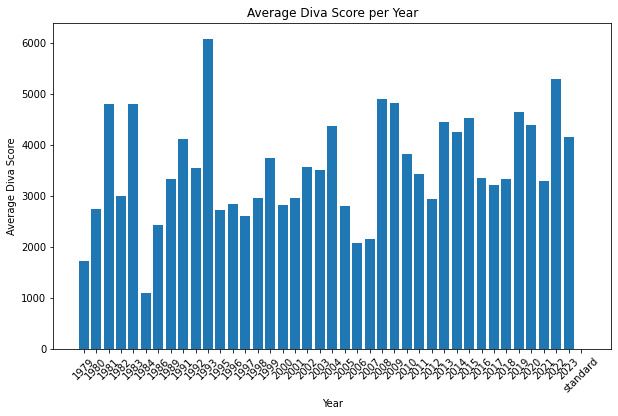

In [3]:
# Diva score by year
df = pd.read_csv('diva_per_id.csv')

def extract_year(id):
    parts = id.split('_')
    return parts[-1]  # Assuming the year is always the last part

df['year'] = df['id'].apply(extract_year)

yearly_stats = df.groupby('year').agg(avg_diva=('score', 'mean'), num_performances=('id', 'count')).reset_index()

yearly_stats.to_csv('diva_per_year.csv', index=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(yearly_stats['year'], yearly_stats['avg_diva'])
plt.xlabel('Year')
plt.ylabel('Average Diva Score')
plt.title('Average Diva Score per Year')
plt.xticks(rotation=45)
plt.show()

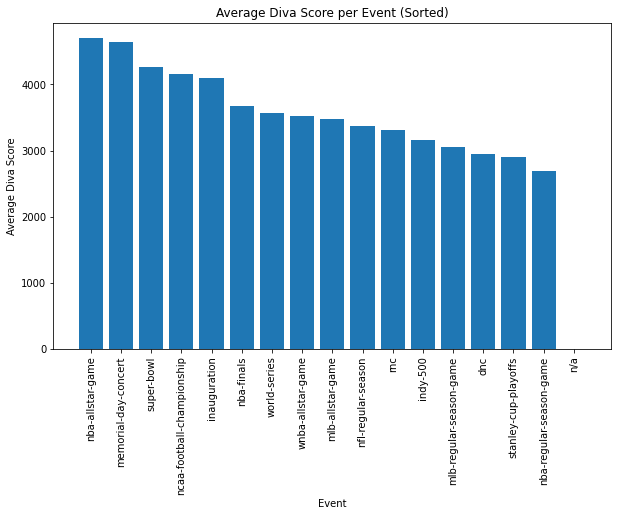

In [18]:
# Diva score by event
df = pd.read_csv('diva_per_id.csv')

# Function to extract event from id
def extract_event(id):
    if id == 'standard': return 'n/a'
    parts = id.split('_')
    return parts[1]  # Assuming the event is always the second part

# Apply the function to extract event
df['event'] = df['id'].apply(extract_event)

# Calculate average diva score and number of performances per event
event_stats = df.groupby('event').agg(avg_diva=('score', 'mean'), num_performances=('id', 'count')).reset_index()

# Sort the DataFrame by avg_diva in descending order
event_stats = event_stats.sort_values(by='avg_diva', ascending=False)

# Save to CSV
event_stats.to_csv('diva_per_event.csv', index=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(event_stats['event'], event_stats['avg_diva'])
plt.xlabel('Event')
plt.ylabel('Average Diva Score')
plt.title('Average Diva Score per Event (Sorted)')
plt.xticks(rotation=90)
plt.show()

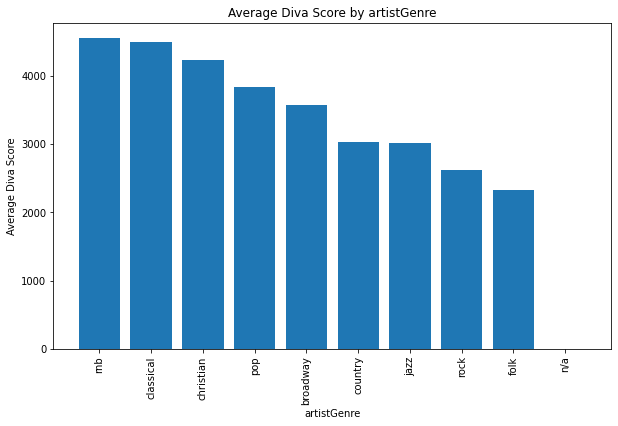

In [19]:
# Diva score by genre OR event type
cut = 'artistGenre'
ids = pd.read_csv('ids.csv')
df = pd.read_csv('diva_per_id.csv')

def extract(id):
    if id == 'standard': return 'n/a'
    match = ids[ids['id'] == id]
    return match[cut].iloc[0]

df[cut] = df['id'].apply(extract)

# Calculate average diva score and number of performances per event
event_stats = df.groupby(cut).agg(avg_diva=('score', 'mean'), num_performances=('id', 'count')).reset_index()

# Sort the DataFrame by avg_diva in descending order
event_stats = event_stats.sort_values(by='avg_diva', ascending=False)

# Save to CSV
event_stats.to_csv(f'diva_per_{cut}.csv', index=False)

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(event_stats[cut], event_stats['avg_diva'])
plt.xlabel(cut)
plt.ylabel('Average Diva Score')
plt.title(f'Average Diva Score by {cut}')
plt.xticks(rotation=90)
plt.show()

## Repeat performers

In [8]:
def extract_performer(id):
    if id == 'standard': return 'n/a'
    parts = id.split('_')
    return parts[0]

ids_df = pd.read_csv('diva_per_id.csv')
ids_df['performer'] = ids_df['id'].apply(extract_performer)
event_stats = ids_df.groupby('performer').agg(avg_diva=('score', 'mean'), num_performances=('id', 'count')).reset_index()
event_stats = event_stats.sort_values(by='avg_diva', ascending=False)

# Save to CSV
event_stats.to_csv('diva_per_performer.csv', index=False)

In [11]:
repeats = event_stats[event_stats['num_performances'] > 2]
print(repeats)

           performer     avg_diva  num_performances
58     jordin-sparks  4604.611853                 4
79      mary-j-blige  4244.487821                 3
30       demi-lovato  3961.261015                 3
49             jewel  3821.281681                 3
63    kelly-clarkson  3671.357689                 3
18  carrie-underwood  2839.925079                 4
13        billy-joel  2361.763824                 4


*
*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[1222.2940100000058, 2639.9612100000045, 1394.9859500000027, 1222.2940100000058, 2312.1911599999944, 1634.3658600000056, 2639.9612100000045, 2312.1911599999944, 2513.0589999999975, 1394.9859500000027, 1634.3658600000056, 2513.0589999999975]
average: 1952.8095316666686


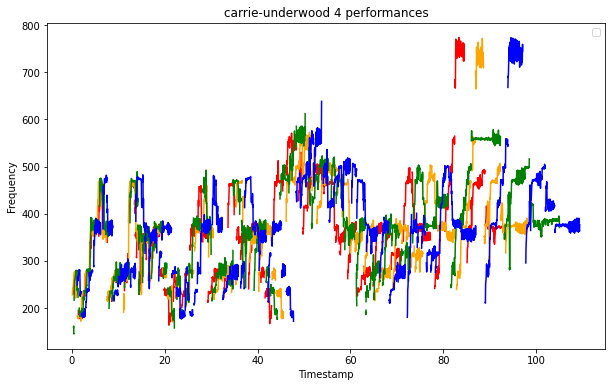

*
*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[6888.735059999995, 4789.541859999988, 6704.2529200000145, 6888.735059999995, 3234.347960000018, 1073.1169199999931, 4789.541859999988, 3234.347960000018, 3117.0549900000015, 6704.2529200000145, 1073.1169199999931, 3117.0549900000015]
average: 4301.174951666669


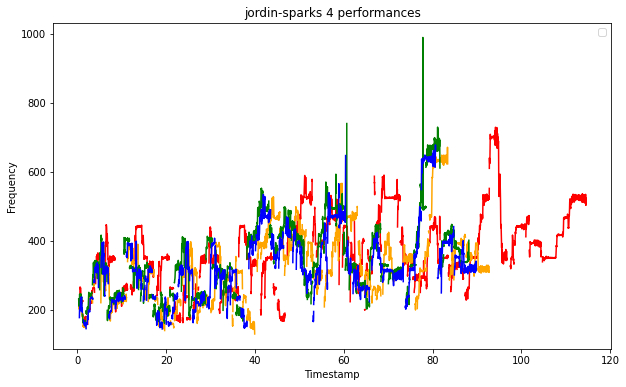

*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[8630.227150000026, 9237.414253999988, 8630.227150000026, 3202.6824640000036, 9237.414253999988, 3202.6824640000036]
average: 7023.44128933334


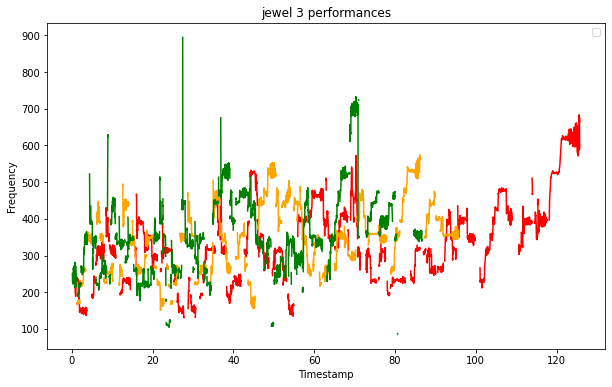

*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[4757.53299, 4723.550789999998, 4757.53299, 4733.736239999985, 4723.550789999998, 4733.736239999985]
average: 4738.273339999993


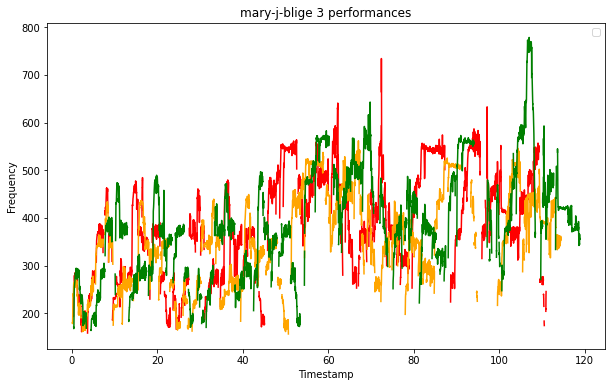

*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[9690.483759999985, 1807.1167099999898, 9690.483759999985, 9563.886570000033, 1807.1167099999898, 9563.886570000033]
average: 7020.495680000003


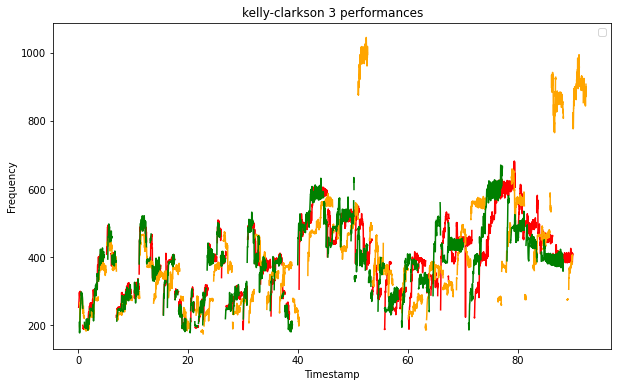

*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[6769.103889999972, 8147.905990000023, 6769.103889999972, 5071.183939999976, 8147.905990000023, 5071.183939999976]
average: 6662.731273333324


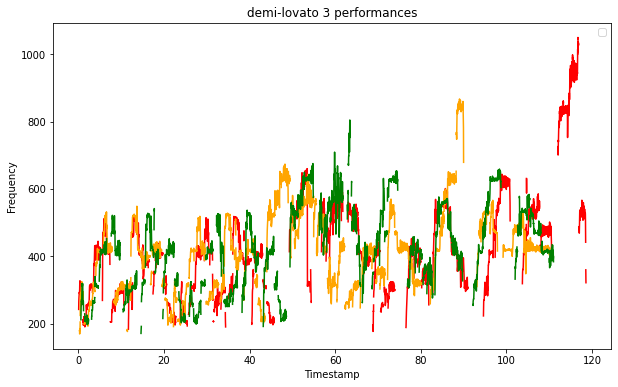

*
*
*
*


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[2368.471523000008, 5558.167832999986, 5409.464542999992, 2368.471523000008, 3080.7301799999786, 3021.1614299999824, 5558.167832999986, 3080.7301799999786, 2177.1819800000103, 5409.464542999992, 3021.1614299999824, 2177.1819800000103]
average: 3602.529581499993


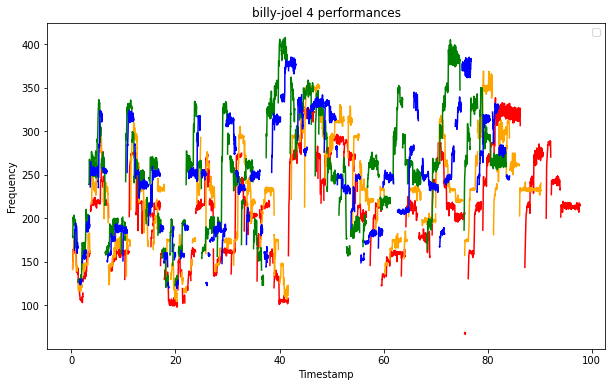

In [36]:
colors = ['red', 'orange', 'green', 'blue', 'purple']
def plot_repeat_performer(name):
    plt.figure(figsize=(10, 6))
    num_performances = 0
    all_performances_data = []
    
    for filename in os.listdir('pitch'):
        if name in filename:
            num_performances += 1
            filepath = os.path.join('pitch', filename)
            data = pd.read_csv(filepath)
            all_performances_data.append(data)
            
            data['group'] = (data['frequency'] == 0).cumsum()
            grouped = data[data['frequency'] != 0].groupby('group')
            # Plot each segment
            for _, segment in grouped:
                plt.plot(segment['timestamp'], segment['frequency'], color=colors[num_performances - 1])
    
    self_similarity(all_performances_data)
    
    plt.xlabel('Timestamp')
    plt.ylabel('Frequency')
    plt.title(f'{name} {num_performances} performances')
    plt.legend()
    plt.show()
    
def self_similarity(all_performances_data):
    comparisons = []
    for i in all_performances_data:
        print('*')
        for j in all_performances_data:
            diva = diva_score(i, j)
            if diva != 0: comparisons.append(diva)
    print(comparisons)
    print(f'average: {avg(comparisons)}')

plot_repeat_performer('carrie-underwood') # 1952.8
plot_repeat_performer('jordin-sparks')    # 4301.1
plot_repeat_performer('jewel')            # 7023.4
plot_repeat_performer('mary-j-blige')     # 4738.2
plot_repeat_performer('kelly-clarkson')   # 7020.4
plot_repeat_performer('demi-lovato')      # 6662.7
plot_repeat_performer('billy-joel')       # 3602.5

# Other thoughts: some performers always do it in the same key (carrie in F#, demi in Ab) but others change
# try a simple re-time scaling on carrie for the chart to line up better OR force phrases to start at the same time

## Originality - Distance Matrix with DTW

In [2]:
def create_distance_matrix(phrase_index):
    # Read IDs
    ids_df = pd.read_csv('ids.csv')
    ids = ids_df['id'].tolist()
    total_ids = len(ids)

    # Create directory if it doesn't exist
    os.makedirs('distance-matrix', exist_ok=True)

    # Initialize the distance matrix
    distance_matrix = pd.DataFrame(index=ids, columns=ids)

    # Loop over each ID
    for i, id1 in enumerate(ids):
        print(f'{i+1}/{total_ids}: {id1}')  # Progress indicator
        with open(f'phrase-starts-and-ends-by-id/{id1}_fixed_phrases.json') as f:
            phrase_data = json.load(f)[phrase_index]  # Get the phrase data

        # Load pitch data
        pitch_df = pd.read_csv(f'pitch-transposed/{id1}_pitch.csv')
        pitch_df = pitch_df[(pitch_df['timestamp'] >= phrase_data['start']) & (pitch_df['timestamp'] <= phrase_data['end'])]

        # Loop over other IDs to calculate distances
        for id2 in ids:
            if id1 != id2:
                with open(f'phrase-starts-and-ends-by-id/{id2}_fixed_phrases.json') as f2:
                    other_phrase_data = json.load(f2)[phrase_index]

                other_pitch_df = pd.read_csv(f'pitch-transposed/{id2}_pitch.csv')
                other_pitch_df = other_pitch_df[(other_pitch_df['timestamp'] >= other_phrase_data['start']) & (other_pitch_df['timestamp'] <= other_phrase_data['end'])]

                # Calculate and store the diva score
                distance_matrix.at[id1, id2] = diva_score(pitch_df, other_pitch_df)

    # Save the distance matrix
    distance_matrix.to_csv(f'distance-matrix/phrase{phrase_index}.csv')

# Example usage: create_distance_matrix(1) for phrase 1
create_distance_matrix(15)

1/137: aaliyah_nba-regular-season-game_1995


NameError: name 'diva_score' is not defined

In [4]:
def originality_rank(phrase_index):
    # Load the distance matrix for the specified phrase
    distance_matrix = pd.read_csv(f'distance-matrix/phrase{phrase_index}.csv', index_col=0)

    # Calculate the average distance for each ID
    average_distances = distance_matrix.mean(axis=1)

    # Sort the IDs by their average distance in descending order
    sorted_ids = average_distances.sort_values(ascending=False)

    return sorted_ids

# Example usage
sorted_originality = originality_rank(15)  # For phrase 1
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print("Originality ranking for phrase 15 (most original to least):")
    print(sorted_originality)

Originality ranking for phrase 1 (most original to least):
renee-fleming_super-bowl_2014                    3955.485560
jewel_nba-allstar-game_2023                      3512.836314
beyonce_super-bowl_2004                          3440.737577
idina-menzel_mlb-allstar-game_2014               3424.664862
patti-labelle_world-series_2008                  2876.166940
kelly-clarkson_world-series_2010                 2595.192411
gladys-knight_super-bowl_2019                    2584.834806
demi-lovato_world-series_2015                    2532.433045
cher_super-bowl_1999                             2520.968230
alicia-keys_super-bowl_2013                      2425.419243
chaka-khan_nba-allstar-game_2020                 2373.231273
mariah-carey_super-bowl_2002                     2224.637488
pia-toscano_memorial-day-concert_2022            1967.444576
jennifer-hudson_super-bowl_2009                  1844.710896
jordan-smith_nfl-regular-season_2023             1707.485029
christina-aguilera_super-b

## DTW Experimentation

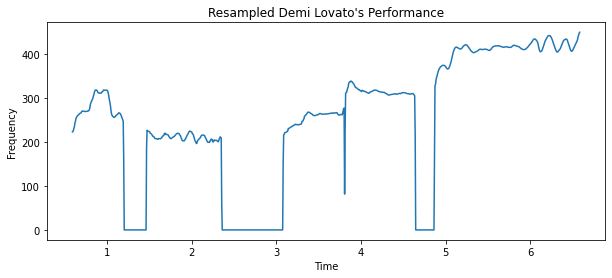

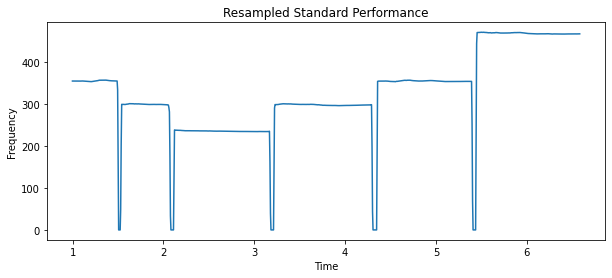

DTW score: 37936.84303740382


<Axes: xlabel='Index', ylabel='Query value'>

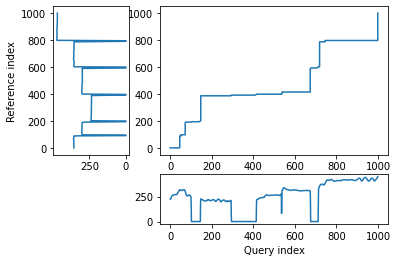

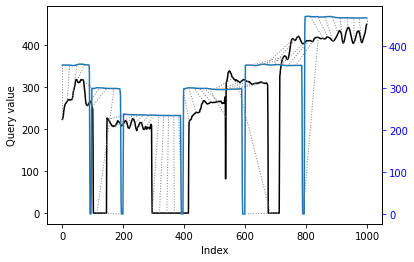

In [19]:
def load_and_filter_pitch_data(pitch_file, phrase_file):
    # Load pitch data
    pitch_data = pd.read_csv(pitch_file)

    # Load phrase data and extract start and end times for the first phrase
    with open(phrase_file, 'r') as file:
        phrases = json.load(file)
    first_phrase = phrases[0]
    start, end = first_phrase['start'], first_phrase['end']

    # Filter pitch data for the first phrase
    return pitch_data[(pitch_data['timestamp'] >= start) & (pitch_data['timestamp'] <= end)]

# Load and filter Demi Lovato's performance
demi_lovato_pitch = load_and_filter_pitch_data(
    'pitch/demi-lovato_world-series_2012_pitch.csv', 
    'phrase-starts-and-ends-by-id/demi-lovato_world-series_2012_fixed_phrases.json')

# Load and filter the standard performance
standard_pitch = load_and_filter_pitch_data(
    'pitch/standard_pitch.csv', 
    'phrase-starts-and-ends-by-id/standard_fixed_phrases.json')

# Determine the longer duration and resample rate
max_duration = max(demi_lovato_pitch['timestamp'].iloc[-1], standard_pitch['timestamp'].iloc[-1])
resample_rate = 1000  # Example rate, you can adjust this

def resample_series(df, max_duration, resample_rate):
    # Original start and end times
    original_start = df['timestamp'].iloc[0]
    original_end = df['timestamp'].iloc[-1]

    # New equally spaced timestamp values within the original duration
    new_timestamps = np.linspace(original_start, original_end, num=resample_rate)

    # Create an interpolating function within the original duration
    interp = interp1d(df['timestamp'], df['frequency'], kind='linear')

    # Interpolated frequency values
    new_frequencies = interp(new_timestamps)

    # Stretch or compress the new frequencies to fit the max_duration
    stretched_timestamps = np.linspace(original_start, max_duration, num=resample_rate)

    return new_frequencies, stretched_timestamps

# Resample both series
query, query_timestamps = resample_series(demi_lovato_pitch, max_duration, resample_rate)
template, template_timestamps = resample_series(standard_pitch, max_duration, resample_rate)

# Plotting the resampled series
plt.figure(figsize=(10, 4))
plt.plot(query_timestamps, query)
plt.title("Resampled Demi Lovato's Performance")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(template_timestamps, template)
plt.title("Resampled Standard Performance")
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# DTW analysis on resampled data
alignment = dtw(query, template, keep_internals=True)
alignment.plot(type="threeway")
print(f"DTW score: {alignment.distance}")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)

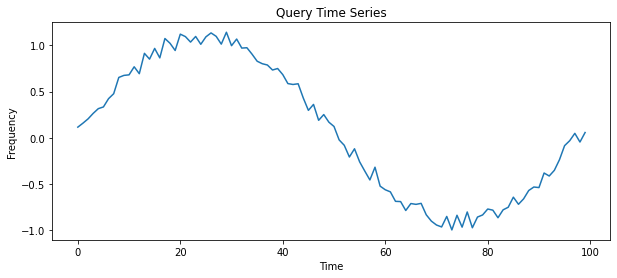

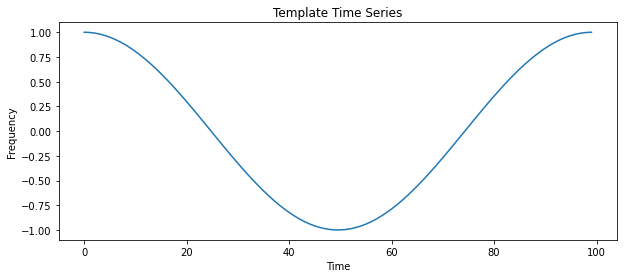

score: 26.894871685687278


<Axes: xlabel='Index', ylabel='Query value'>

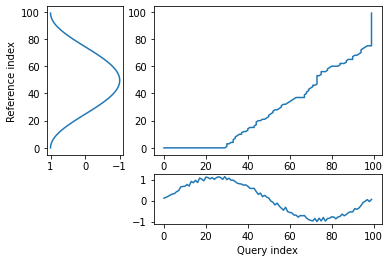

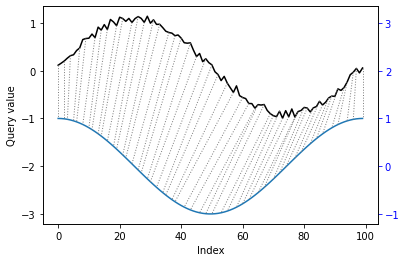

In [16]:
## A noisy sine wave as query
idx = np.linspace(0,6.28,num=100)
query = np.sin(idx) + np.random.uniform(size=100)/5

## A cosine is for template; sin and cos are offset by 25 samples
template = np.cos(idx)

# Plotting 'query'
plt.figure(figsize=(10, 4))
plt.plot(query)
plt.title('Query Time Series')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Plotting 'template'
plt.figure(figsize=(10, 4))
plt.plot(template)
plt.title('Template Time Series')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

## Find the best match with the canonical recursion formula
alignment = dtw(query, template, keep_internals=True)

## Display the warping curve, i.e. the alignment curve
alignment.plot(type="threeway")

print(f"score: {alignment.distance}")

## Align and plot with the Rabiner-Juang type VI-c unsmoothed recursion
dtw(query, template, keep_internals=True, 
    step_pattern=rabinerJuangStepPattern(6, "c"))\
    .plot(type="twoway",offset=-2)